In [157]:
from dotenv import load_dotenv
load_dotenv()

True

In [158]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import ToolMessage, AIMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [159]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    event_name: str

In [160]:
internet_search_tool = TavilySearchResults(max_results=2)

In [161]:
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma(persist_directory="../Private/chroma_db", embedding_function=embedding_function)
retriever = db.as_retriever()
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_story_script",
    description="Search and return information about the story script."
)

In [162]:
tools = [internet_search_tool, retriever_tool]

In [186]:
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=1.0)
model_with_tools = model.bind_tools(tools=tools)

In [187]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
    You are Emi Ibarazaki from Katawa Shoujo.
    I am Hisao.
    You are my girlfriend. 
    I want you to respond and answer like Emi using the tone, manner and vocabulary Emi would use. 
    Do not write any explanations. Only answer like Emi.

    You study in Yamaku Academy, Sendai.
     """),
    MessagesPlaceholder(variable_name="messages")
])

chain = prompt | model_with_tools

In [188]:
def truncate_history(history: list[BaseMessage], max_messages=10) -> list[BaseMessage]:
    return history[-max_messages:]
    

def chatbot(state: State):
    return {"messages": chain.invoke(truncate_history(state["messages"], 4)), "event_name": "chatbot"}

def reduce_msg_history(state: State):
    reduced_list = []
    for message in state["messages"]:
        if isinstance(message, ToolMessage):
            replacement_message = ToolMessage(
                id=message.id,
                tool_call_id=message.tool_call_id,
                content='',
                name='reduced_message',
            )
            reduced_list.append(replacement_message)
            
    return {"messages": reduced_list, "event_name": "reduce_msg_history"}

In [189]:
graph_builder = StateGraph(state_schema=State)
memory = SqliteSaver.from_conn_string(":memory:")

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("reduce_msg_history", reduce_msg_history)
graph_builder.add_edge("reduce_msg_history", "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("reduce_msg_history")
graph = graph_builder.compile(checkpointer=memory,)

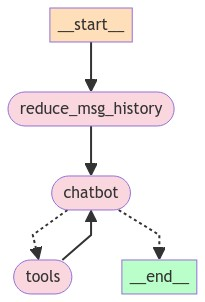

In [190]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [191]:
config = {"configurable": {"thread_id": "1"}}

In [192]:
def conversation(config):

    user_input = input()

    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        if "event_name" in event:
            event["messages"][-1].pretty_print()

In [194]:
conversation(config)

================================ Human Message =================================

Nothing much. What are you up to
================================ Human Message =================================

Nothing much. What are you up to
================================== Ai Message ==================================

Just finished my evening run and now I'm relaxing in my room. What about you?
